# Homework 3: Clasificación en Machine Learning

## Solución a las preguntas del homework

En esta notebook se encuentran las respuestas a las preguntas del homework 3 del Machine Learning Zoomcamp 2025.

### Datos utilizados
Para este homework utilizaremos el dataset de **Lead Scoring (Bank Marketing)** que contiene información sobre clientes potenciales y si se convirtieron o no en clientes. El objetivo es predecir la variable `converted` que indica si un cliente se ha registrado en la plataforma.

In [7]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mutual_info_score

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Librerías importadas correctamente")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Sklearn version: {sklearn.__version__}")

Librerías importadas correctamente
Pandas version: 2.3.3
NumPy version: 2.3.3
Sklearn version: 1.7.2


In [8]:
# Descargar el dataset de lead scoring
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-13 15:45:33--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.03s   

2025-10-13 15:45:34 (2.83 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [9]:
!mv course_lead_scoring.csv ./data

In [10]:
!ls data

course_lead_scoring.csv


## Cargar y explorar los datos

In [11]:
df = pd.read_csv('./data/course_lead_scoring.csv')
print(f"Forma del dataset: {df.shape}")

Forma del dataset: (1462, 9)


In [12]:
print(f"Columnas disponibles: {df.columns.tolist()}")

Columnas disponibles: ['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score', 'converted']


In [13]:
print(f"Primeras 5 filas:")
df.head()

Primeras 5 filas:


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [14]:
# Información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


## Preparación de datos

Verificamos valores faltantes y los manejamos según las instrucciones:
- Categóricos: reemplazar con 'NA'
- Numéricos: reemplazar con 0.0


In [15]:
# Verificar valores faltantes
print("VALORES FALTANTES POR COLUMNA")
print("=" * 50)
missing_info = pd.DataFrame({
    'Valores Faltantes': df.isnull().sum(),
    'Porcentaje': (df.isnull().sum() / len(df)) * 100
})
print(missing_info[missing_info['Valores Faltantes'] > 0])

VALORES FALTANTES POR COLUMNA
                   Valores Faltantes  Porcentaje
lead_source                      128    8.755130
industry                         134    9.165527
annual_income                    181   12.380301
employment_status                100    6.839945
location                          63    4.309166


### Identificar columnas categóricas y numéricas

In [16]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nColumnas categóricas: {categorical_cols}")
print(f"Columnas numéricas: {numerical_cols}")


Columnas categóricas: ['lead_source', 'industry', 'employment_status', 'location']
Columnas numéricas: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score', 'converted']


In [17]:
# Aplicar el manejo de valores faltantes
# Reemplazar valores faltantes en columnas categóricas con 'NA'
for col in categorical_cols:
    df[col] = df[col].fillna('NA')

# Reemplazar valores faltantes en columnas numéricas con 0.0
for col in numerical_cols:
    if col != 'converted':  # No modificar la variable objetivo
        df[col] = df[col].fillna(0.0)

print("\nValores faltantes después de la limpieza:")
print(df.isnull().sum().sum())


Valores faltantes después de la limpieza:
0


## Question 1: Moda de la columna 'industry'

**Pregunta:** ¿Cuál es la observación más frecuente (moda) para la columna `industry`?

In [18]:
# Calcular la moda de 'industry'
mode_industry = df['industry'].mode()[0]
print(f"La moda de 'industry' es: {mode_industry}")

# Ver la distribución completa
print(f"\nDistribución de 'industry':")
print(df['industry'].value_counts())

La moda de 'industry' es: retail

Distribución de 'industry':
industry
retail           203
finance          200
other            198
healthcare       187
education        187
technology       179
manufacturing    174
NA               134
Name: count, dtype: int64


## Question 2: Correlación entre variables numéricas

**Pregunta:** Crear la matriz de correlación para las variables numéricas del dataset. ¿Cuáles son las dos características que tienen la mayor correlación?

In [22]:
# Calcular la matriz de correlación para variables numéricas (excluyendo 'converted')
numerical_features = [col for col in numerical_cols if col != 'converted']
correlation_matrix = df[numerical_features].corr()

print("Matriz de correlación:")

Matriz de correlación:


In [23]:
correlation_matrix

,number_of_courses_viewed,annual_income,interaction_count,lead_score
number_of_courses_viewed,1.000000,0.009770,-0.023565,-0.004879
annual_income,0.009770,1.000000,0.027036,0.015610
interaction_count,-0.023565,0.027036,1.000000,0.009888
lead_score,-0.004879,0.015610,0.009888,1.000000


In [32]:
# Verificar las correlaciones específicas de las opciones
pairs_to_check = [
    ('interaction_count', 'lead_score'),
    ('number_of_courses_viewed', 'lead_score'),
    ('number_of_courses_viewed', 'interaction_count'),
    ('annual_income', 'interaction_count')
]

print("Correlaciones de los pares especificados:\n")
for var1, var2 in pairs_to_check:
    if var1 in correlation_matrix.columns and var2 in correlation_matrix.columns:
        corr_value = correlation_matrix.loc[var1, var2]
        print(f"{var1} vs {var2}: {corr_value:.4f}")

Correlaciones de los pares especificados:

interaction_count vs lead_score: 0.0099
number_of_courses_viewed vs lead_score: -0.0049
number_of_courses_viewed vs interaction_count: -0.0236
annual_income vs interaction_count: 0.0270


In [33]:
# Encontrar la mayor correlación entre los pares especificados
max_corr = 0
max_pair = None

for var1, var2 in pairs_to_check:
    if var1 in correlation_matrix.columns and var2 in correlation_matrix.columns:
        corr_value = abs(correlation_matrix.loc[var1, var2])
        if corr_value > max_corr:
            max_corr = corr_value
            max_pair = (var1, var2)

print(f"{max_pair[0]} y {max_pair[1]} (correlación: {max_corr:.4f})")

annual_income y interaction_count (correlación: 0.0270)


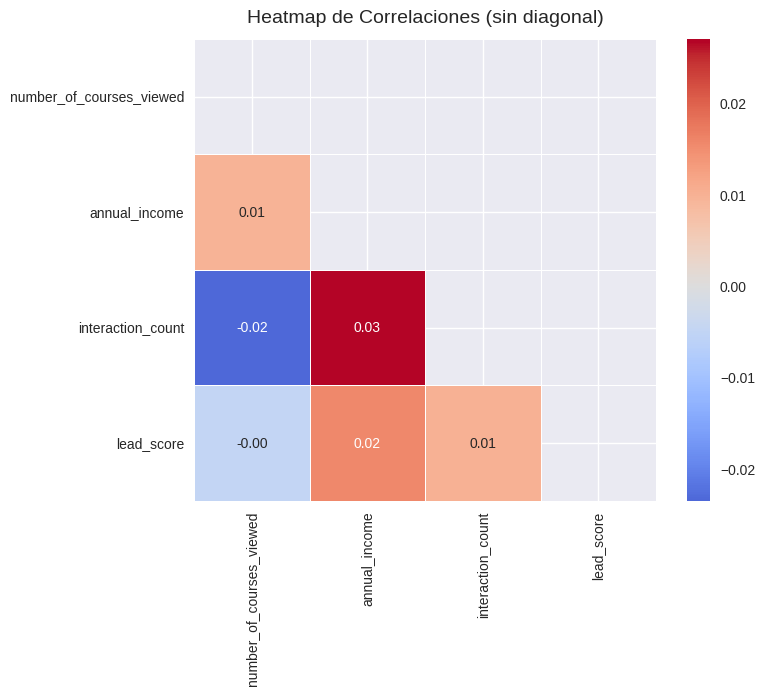

In [27]:
# Crear una máscara para ocultar la mitad superior + diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    square=True
)
plt.title("Heatmap de Correlaciones (sin diagonal)", fontsize=14, pad=12)
plt.show()

### División de datos (Train/Val/Test)

**Instrucciones:**
- Dividir los datos en conjuntos de entrenamiento/validación/prueba con distribución 60%/20%/20%
- Usar `train_test_split` de Scikit-Learn con `seed=42`
- Asegurarse de que la variable objetivo `converted` no esté en el dataframe de features

In [35]:
# Primero dividir train (60%) vs temp (40%)
df_train_full, df_temp = train_test_split(df, test_size=0.4, random_state=42)

# Luego dividir temp en val (20%) y test (20%)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

In [39]:
print(f"Tamaño del conjunto de entrenamiento: {len(df_train_full)} ({len(df_train_full)/len(df)*100:.1f}%) -> shape: {df_train_full.shape}")
print(f"Tamaño del conjunto de validación: {len(df_val)} ({len(df_val)/len(df)*100:.1f}%) -> shape: {df_val.shape}")
print(f"Tamaño del conjunto de prueba: {len(df_test)} ({len(df_test)/len(df)*100:.1f}%) -> shape: {df_test.shape}")

Tamaño del conjunto de entrenamiento: 877 (60.0%) -> shape: (877, 9)
Tamaño del conjunto de validación: 292 (20.0%) -> shape: (292, 9)
Tamaño del conjunto de prueba: 293 (20.0%) -> shape: (293, 9)


In [37]:
# Separar features de la variable objetivo
y_train = df_train_full['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

In [ ]:
# Eliminar la columna 'converted' de los dataframes
df_train_full = df_train_full.drop('converted', axis=1).reset_index(drop=True)
df_val = df_val.drop('converted', axis=1).reset_index(drop=True)
df_test = df_test.drop('converted', axis=1).reset_index(drop=True)

In [38]:
print(f"\nForma del conjunto de entrenamiento: {df_train_full.shape}")
print(f"Forma del conjunto de validación: {df_val.shape}")
print(f"Forma del conjunto de prueba: {df_test.shape}")


Forma del conjunto de entrenamiento: (877, 9)
Forma del conjunto de validación: (292, 9)
Forma del conjunto de prueba: (293, 9)


## Question 3: Mutual Information Score

**Pregunta:** Calcular el mutual information score entre `converted` y otras variables categóricas del dataset usando solo el conjunto de entrenamiento. Redondear los scores a 2 decimales usando `round(score, 2)`.

¿Cuál de estas variables tiene el mayor mutual information score?

In [40]:
# Identificar variables categóricas en el conjunto de entrenamiento
categorical_features = df_train_full.select_dtypes(include=['object']).columns.tolist()

print("Variables categóricas encontradas:")
print(categorical_features)

Variables categóricas encontradas:
['lead_source', 'industry', 'employment_status', 'location']


In [47]:
# Diccionario para guardar resultados
mi_scores = {}

# Calcular la información mutua para cada feature categórica
for col in categorical_features:
    mi_score = mutual_info_score(df_train_full[col], y_train)
    mi_scores[col] = round(mi_score, 2)

mi_scores

{'lead_source': 0.03,
 'industry': 0.02,
 'employment_status': 0.02,
 'location': 0.0}

In [46]:
# Crear un DataFrame a partir del diccionario
mi_df = pd.DataFrame(
    list(mi_scores.items()),
    columns=["Feature", "Mutual Information Score"]
).sort_values(by="Mutual Information Score", ascending=False).reset_index(drop=True)

# Mostrar el DataFrame resultante
mi_df

,Feature,Mutual Information Score
0,lead_source,0.03
1,industry,0.02
2,employment_status,0.02
3,location,0.00


### Preparar datos con one-hot encoding usando DictVectorizer

In [49]:
train_dicts = df_train_full.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

In [50]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [51]:
print(f"Forma de X_train después de one-hot encoding: {X_train.shape}")
print(f"Forma de X_val después de one-hot encoding: {X_val.shape}")

Forma de X_train después de one-hot encoding: (877, 32)
Forma de X_val después de one-hot encoding: (292, 32)


## Question 4: Regresión Logística

**Pregunta:** Entrenar una regresión logística incluyendo las variables categóricas usando one-hot encoding. Ajustar el modelo en el conjunto de entrenamiento con los siguientes parámetros para asegurar reproducibilidad:

```python
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
```

Calcular el accuracy en el conjunto de validación y redondearlo a 2 decimales.

¿Qué accuracy obtuviste?

In [52]:
# Entrenar el modelo de regresión logística
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

print("Modelo entrenado correctamente")

Modelo entrenado correctamente


In [54]:
# Calcular accuracy en validación
y_pred_val = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)
accuracy

0.8424657534246576

In [55]:
accuracy_rounded = round(accuracy, 2)
print(f"Accuracy val: {accuracy_rounded}")

Accuracy val: 0.84


In [ ]:
Aquí está el texto en formato markdown para las preguntas 2 a 6, siguiendo el mismo formato de la pregunta 1:





---



---

## Question 5: Eliminación de características

**Pregunta:** Encontrar la característica menos útil usando la técnica de eliminación de características (_feature elimination_). Entrenar un modelo usando las mismas características y parámetros que en Q4 (sin redondear). Luego excluir cada característica de este conjunto y entrenar un modelo sin ella. Registrar el accuracy para cada modelo.

Para cada característica, calcular la diferencia entre el accuracy original y el accuracy sin la característica.

¿Cuál de las siguientes características tiene la menor diferencia?

**Opciones:**
- `'industry'`
- `'employment_status'`
- `'lead_score'`

*Nota: La diferencia no tiene que ser positiva.*

---

## Question 6: Regularización

**Pregunta:** Entrenar una regresión logística regularizada probando los siguientes valores del parámetro `C`: `[0.01, 0.1, 1, 10, 100]`. Entrenar modelos usando todas las características como en Q4. Calcular el accuracy en el conjunto de validación y redondearlo a 3 decimales.

¿Cuál de estos valores de `C` conduce al mejor accuracy en el conjunto de validación?

**Opciones:**
- 0.01
- 0.1
- 1
- 10
- 100

*Nota: Si hay múltiples opciones con el mismo accuracy, seleccionar el menor valor de `C`.*

---

Este texto está listo para ser insertado en el notebook manteniendo el mismo formato profesional y claro de la pregunta 1. 📝

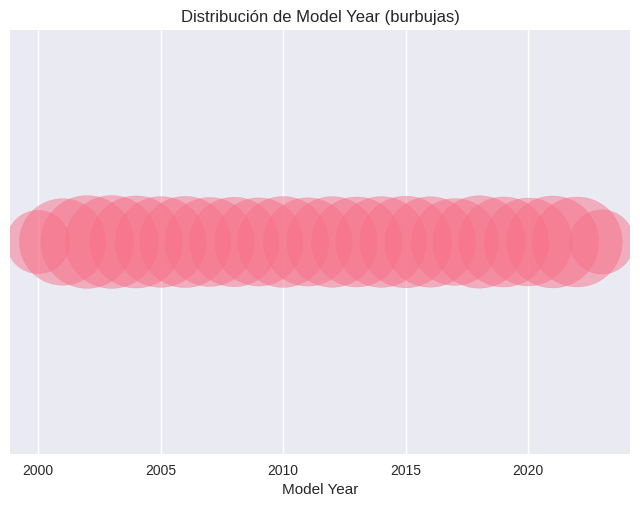

In [ ]:
## Question 5: Feature Elimination

**Pregunta:** Encontrar la característica menos útil usando la técnica de eliminación de características. Entrenar modelos excluyendo cada característica y registrar el accuracy. Para cada característica, calcular la diferencia entre el accuracy original y el accuracy sin esa característica.

¿Cuál de las siguientes características tiene la menor diferencia?

**Opciones:**
- `'industry'`
- `'employment_status'`
- `'lead_score'`

# Obtener el accuracy original (sin redondear para precisión)
y_pred_original = model.predict(X_val)
accuracy_original = accuracy_score(y_val, y_pred_original)
print(f"Accuracy original: {accuracy_original:.6f}")

In [ ]:
# Evaluar eliminando cada característica
features_to_test = ['industry', 'employment_status', 'lead_score']
feature_importance = {}

for feature in features_to_test:
    # Crear dataframes sin la característica
    df_train_no_feat = df_train_full.drop(feature, axis=1, errors='ignore')
    df_val_no_feat = df_val.drop(feature, axis=1, errors='ignore')
    
    # Preparar datos con one-hot encoding
    train_dicts_no_feat = df_train_no_feat.to_dict(orient='records')
    val_dicts_no_feat = df_val_no_feat.to_dict(orient='records')
    
    dv_no_feat = DictVectorizer(sparse=False)
    X_train_no_feat = dv_no_feat.fit_transform(train_dicts_no_feat)
    X_val_no_feat = dv_no_feat.transform(val_dicts_no_feat)
    
    # Entrenar modelo sin la característica
    model_no_feat = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model_no_feat.fit(X_train_no_feat, y_train)
    
    # Calcular accuracy
    y_pred_no_feat = model_no_feat.predict(X_val_no_feat)
    accuracy_no_feat = accuracy_score(y_val, y_pred_no_feat)
    
    # Calcular la diferencia
    diff = accuracy_original - accuracy_no_feat
    feature_importance[feature] = diff
    
    print(f"Feature '{feature}': accuracy sin ella = {accuracy_no_feat:.6f}, diferencia = {diff:.6f}")

count    8996.000000
mean      149.657292
std        29.879555
min        37.000000
25%       130.000000
50%       149.000000
75%       170.000000
max       271.000000
Name: horsepower, dtype: float64

In [ ]:
# Encontrar la característica con la menor diferencia (menos útil)
min_diff_feature = min(feature_importance, key=feature_importance.get)
min_diff = feature_importance[min_diff_feature]

print(f"\n**Respuesta Q5:** '{min_diff_feature}' tiene la menor diferencia ({min_diff:.6f})")

,horsepower,count
0,152.0,142
1,145.0,141
2,151.0,134
3,148.0,130
4,141.0,130
...,...,...
187,40.0,1
188,57.0,1
189,245.0,1
190,252.0,1


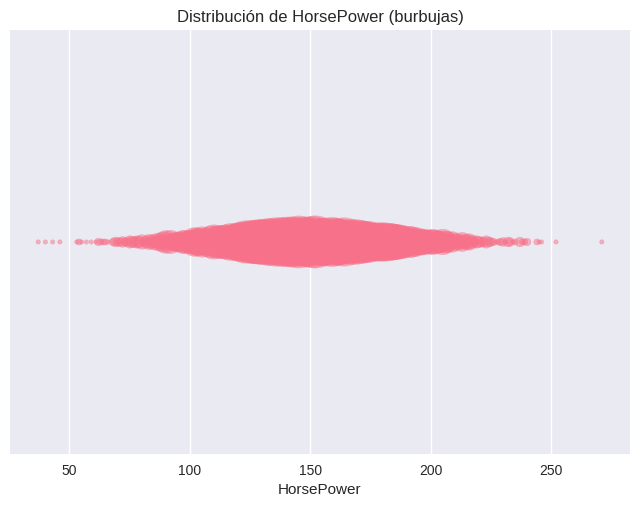

In [ ]:
## Question 6: Regularización

**Pregunta:** Entrenar una regresión logística regularizada con diferentes valores de `C`: `[0.01, 0.1, 1, 10, 100]`. Usar todas las características como en Q4. Calcular el accuracy en validación y redondearlo a 3 decimales.

¿Cuál de estos valores de `C` conduce al mejor accuracy en el conjunto de validación? (Si hay empate, seleccionar el menor `C`)

**Opciones:**
- 0.01
- 0.1
- 1
- 10
- 100

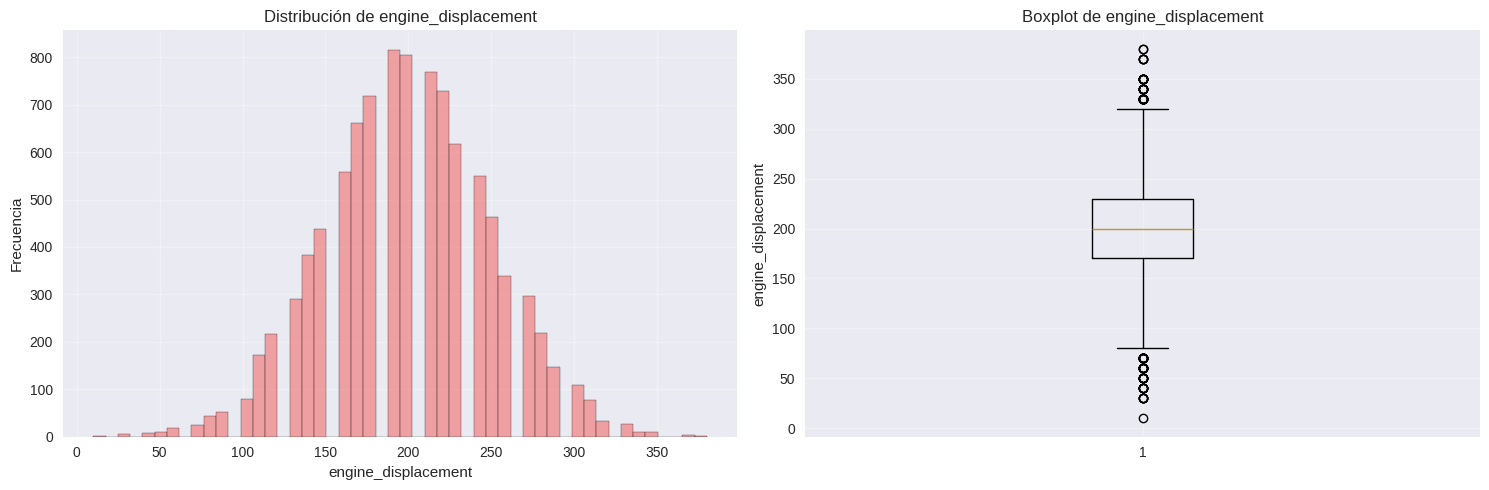

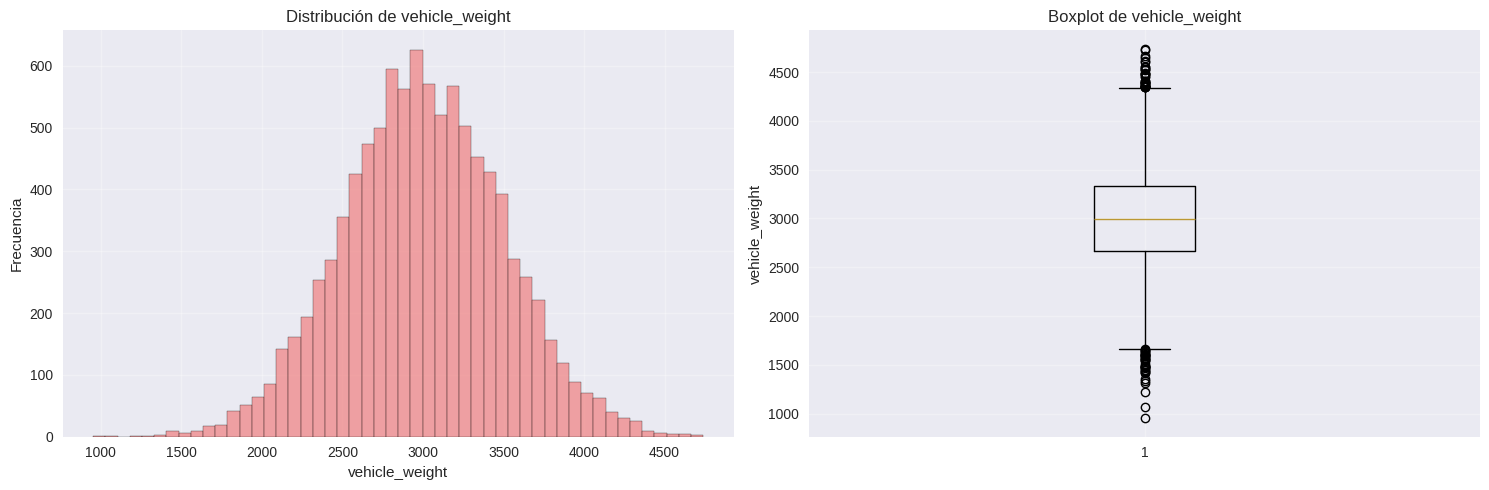

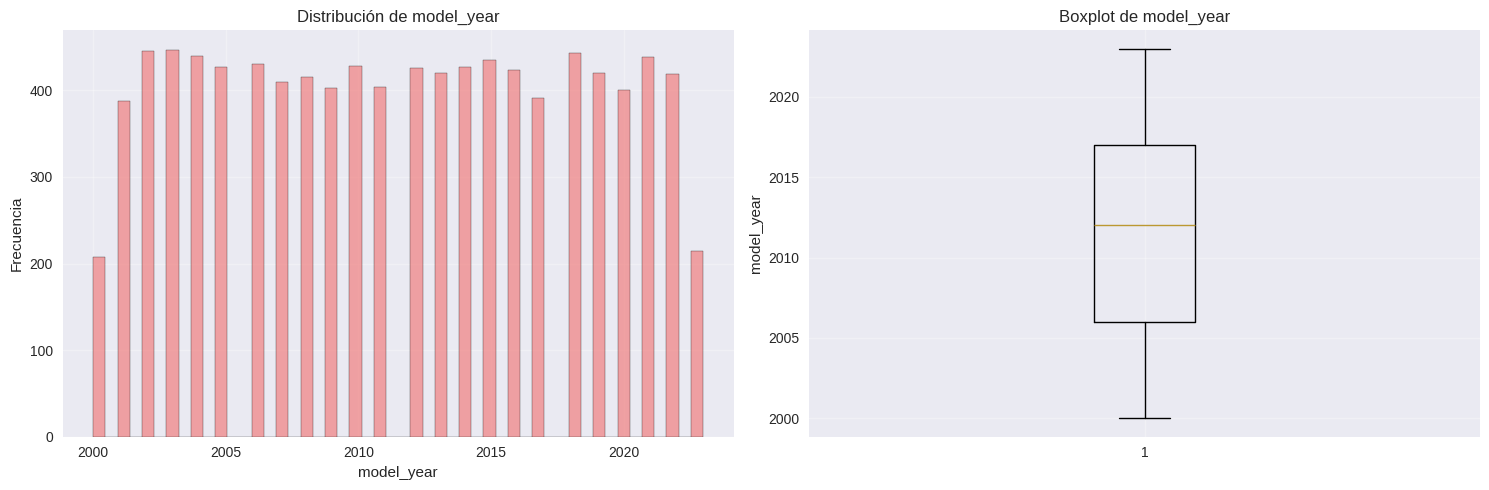

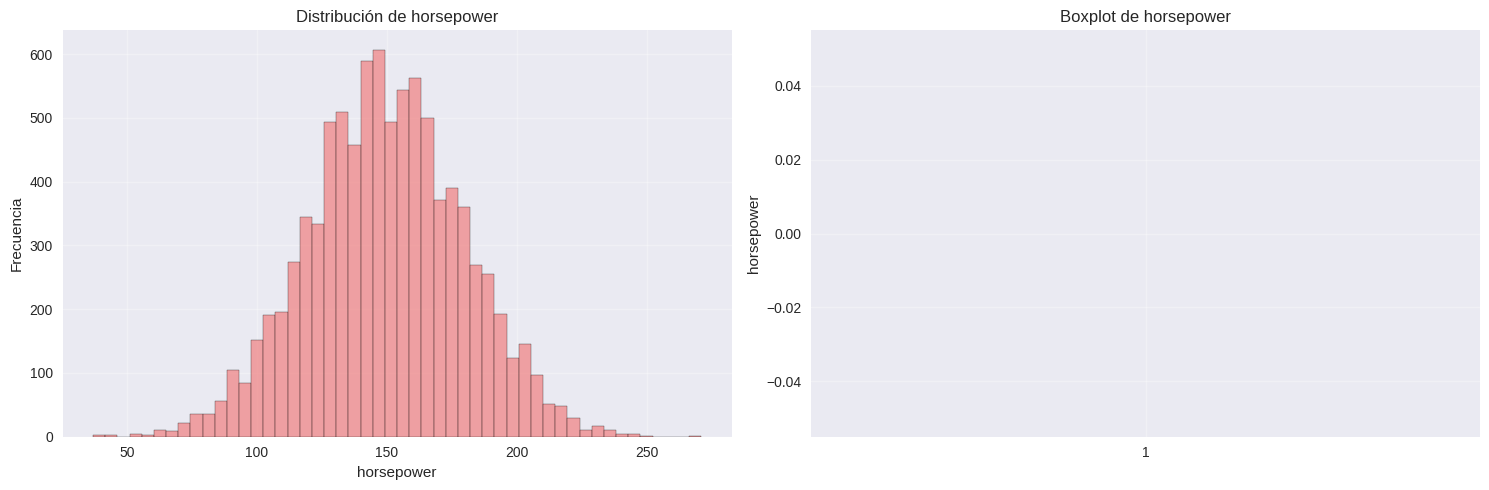

In [ ]:
# Probar diferentes valores de C
C_values = [0.01, 0.1, 1, 10, 100]
results = {}

for C in C_values:
    # Entrenar modelo con el valor de C especificado
    model_c = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model_c.fit(X_train, y_train)
    
    # Calcular accuracy en validación
    y_pred_c = model_c.predict(X_val)
    accuracy_c = accuracy_score(y_val, y_pred_c)
    accuracy_c_rounded = round(accuracy_c, 3)
    
    results[C] = accuracy_c_rounded
    print(f"C={C}: accuracy = {accuracy_c_rounded}")


In [ ]:
# Encontrar el mejor C (el menor si hay empate)
max_accuracy = max(results.values())
best_C = min([c for c, acc in results.items() if acc == max_accuracy])

print(f"\n**Respuesta Q6:** C={best_C} con accuracy de {max_accuracy}")

In [ ]:
## Resumen de respuestas

Veamos todas las respuestas del homework:

In [ ]:
print("=" * 60)
print("RESUMEN DE RESPUESTAS - HOMEWORK 3")
print("=" * 60)
print(f"Q1 - Moda de 'industry': {mode_industry}")
print(f"Q2 - Mayor correlación: {max_pair[0]} y {max_pair[1]}")
print(f"Q3 - Mayor MI score: {max_var}")
print(f"Q4 - Accuracy de regresión logística: {accuracy_rounded}")
print(f"Q5 - Característica menos útil: {min_diff_feature}")
print(f"Q6 - Mejor valor de C: {best_C}")
print("=" * 60)

In [ ]:
# Visualización de la distribución de la variable objetivo
print("\nDistribución de la variable objetivo 'converted':")
print(pd.Series(y_train).value_counts())
print(f"\nPorcentaje de conversión: {pd.Series(y_train).mean()*100:.2f}%")

Cantidad de registros: 9704
Entrenamiento 60%: 5824
Validación 20%: 1940
Prueba 20%: 1940


array([   0,    1,    2, ..., 9701, 9702, 9703], shape=(9704,))

array([ 483, 7506, 8795, ..., 5390,  860, 7270], shape=(9704,))

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
483,220,144.0,2535.887591,2009,16.642943
7506,160,141.0,2741.170484,2019,16.298377
8795,230,155.0,2471.880237,2017,18.591822
1688,150,206.0,3748.164469,2015,11.818843
6217,300,111.0,2135.716359,2006,19.402209


,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
6163,180,112.0,2772.134410,2020,15.366341
3313,260,138.0,3014.061530,2022,14.601182
4781,140,181.0,3652.186151,2016,12.247032
8210,270,105.0,2753.040847,2023,15.136400
6713,170,224.0,4163.375137,2003,10.340419


,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
3729,140,148.0,2704.826005,2017,15.804354
7764,210,136.0,3001.227490,2004,14.272374
4358,210,152.0,3747.467392,2021,11.748441
5922,190,128.0,2705.833636,2014,16.485991
1343,230,156.0,2505.939657,2005,17.779704


np.float64(149.54476367006487)

[{'horsepower_0': {'horsepower': 0}},
 {'horsepower_mean': {'horsepower': 149.54476367006487}}]

Entrenando modelo usando horsepower_0
Aplicando fillna segun clave:valor -> {'horsepower': 0}
Entrenando modelo...
Evaluando...
RMSE train 0.5203
RMSE val 0.5174
...
Entrenando modelo usando horsepower_mean
Aplicando fillna segun clave:valor -> {'horsepower': 149.54476367006487}
Entrenando modelo...
Evaluando...
RMSE train 0.4624
RMSE val 0.4636
...


,estrategia_fillna,rmse_train,rmse_val
0,{'horsepower': 0},0.5203,0.5174
1,{'horsepower': 149.54476367006487},0.4624,0.4636


<class 'pandas.core.series.Series'>
RangeIndex: 5824 entries, 0 to 5823
Series name: horsepower
Non-Null Count  Dtype  
--------------  -----  
5395 non-null   float64
dtypes: float64(1)
memory usage: 45.6 KB


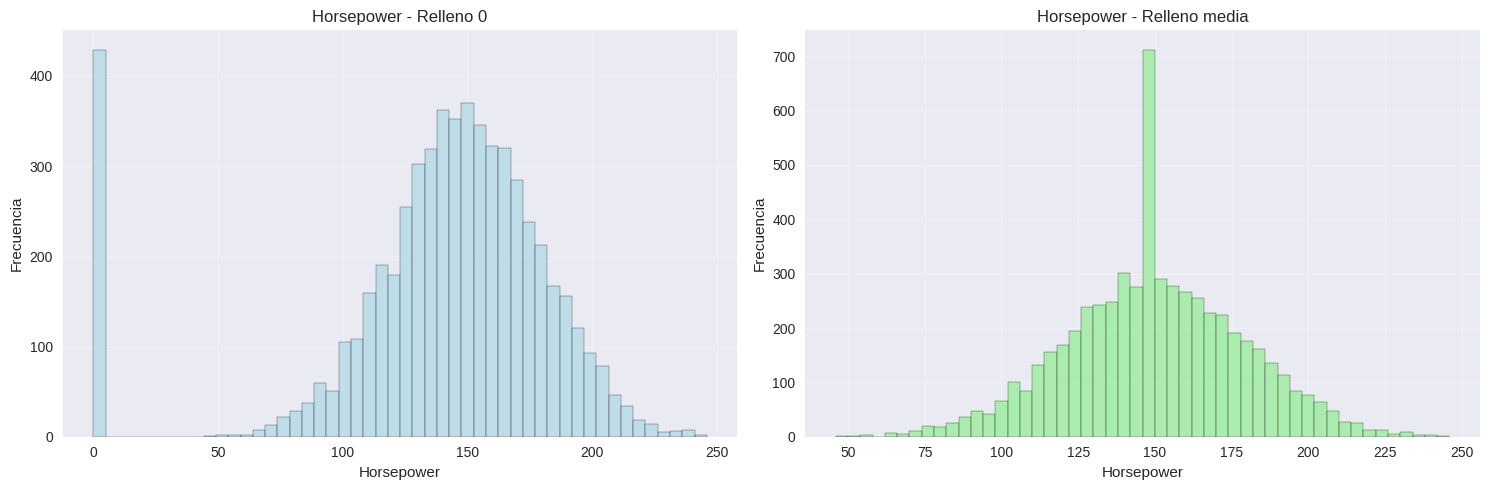

[0, 0.01, 0.1, 1, 5, 10, 100]

Entrenando modelo usando regularizacio r:0
Aplicando fillna con valor 0...
Entrenando modelo...
Evaluando...
RMSE train 0.52
RMSE val 0.52
...
Entrenando modelo usando regularizacio r:0.01
Aplicando fillna con valor 0...
Entrenando modelo...
Evaluando...
RMSE train 0.52
RMSE val 0.52
...
Entrenando modelo usando regularizacio r:0.1
Aplicando fillna con valor 0...
Entrenando modelo...
Evaluando...
RMSE train 0.52
RMSE val 0.52
...
Entrenando modelo usando regularizacio r:1
Aplicando fillna con valor 0...
Entrenando modelo...
Evaluando...
RMSE train 0.53
RMSE val 0.52
...
Entrenando modelo usando regularizacio r:5
Aplicando fillna con valor 0...
Entrenando modelo...
Evaluando...
RMSE train 0.53
RMSE val 0.52
...
Entrenando modelo usando regularizacio r:10
Aplicando fillna con valor 0...
Entrenando modelo...
Evaluando...
RMSE train 0.53
RMSE val 0.52
...
Entrenando modelo usando regularizacio r:100
Aplicando fillna con valor 0...
Entrenando modelo...
Evaluando...
RMSE train 0.53
RMSE val 

,r,rmse_train,rmse_val
0,0.00,0.52,0.52
1,0.01,0.52,0.52
2,0.10,0.52,0.52
3,1.00,0.53,0.52
4,5.00,0.53,0.52
5,10.00,0.53,0.52
6,100.00,0.53,0.52


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Aplicando fillna con valor 0...
Entrenando modelo...
Evaluando...
RMSE train 0.5171560913636251
RMSE val 0.5206531296294218
...
Aplicando fillna con valor 0...
Entrenando modelo...
Evaluando...
RMSE train 0.5148529296311273
RMSE val 0.521338891285577
...
Aplicando fillna con valor 0...
Entrenando modelo...
Evaluando...
RMSE train 0.520558311480986
RMSE val 0.5228069974803171
...
Aplicando fillna con valor 0...
Entrenando modelo...
Evaluando...
RMSE train 0.5198664820191077
RMSE val 0.515951674119676
...
Aplicando fillna con valor 0...
Entrenando modelo...
Evaluando...
RMSE train 0.5171675510792179
RMSE val 0.5109129460053851
...
Aplicando fillna con valor 0...
Entrenando modelo...
Evaluando...
RMSE train 0.5195177528194667
RMSE val 0.52834064601107
...
Aplicando fillna con valor 0...
Entrenando modelo...
Evaluando...
RMSE train 0.5124114964022372
RMSE val 0.5313910658146311
...
Aplicando fillna con valor 0...
Entrenando modelo...
Evaluando...
RMSE train 0.524763629954572
RMSE val 0.509

,seed,rmse_train,rmse_val
0,0,0.517156,0.520653
1,1,0.514853,0.521339
2,2,0.520558,0.522807
3,3,0.519866,0.515952
4,4,0.517168,0.510913
5,5,0.519518,0.528341
6,6,0.512411,0.531391
7,7,0.524764,0.509067
8,8,0.524306,0.514740
9,9,0.521971,0.513187


array([0.52065313, 0.52133889, 0.522807  , 0.51595167, 0.51091295,
       0.52834065, 0.53139107, 0.50906704, 0.51473991, 0.51318659])

np.float64(0.007)

np.float64(0.006989446426433706)

Entrenando modelo usando regularizacio r:0.001
Aplicando fillna con valor 0...
Entrenando modelo...
Evaluando...
RMSE train_val 0.5197448026201177
RMSE test 0.5156261299169602
...


,r,rmse_train_val,rmse_test
0,0.001,0.519745,0.515626
